<a href="https://colab.research.google.com/github/KiruthikaSelvaraj1/primetrade-trader-sentiment-analysis-internship/blob/main/trader_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Trader Performance vs Market Sentiment Analysis

**Candidate Name:** Kiruthika S  
**Role:** Data Science Intern - Round 0 Assignment  
**Company:** Primetrade.ai  

#Objective
The goal of this analysis is to study how Bitcoin market sentiment
(Fear vs Greed) influences trader behavior and performance on the
Hyperliquid platform. The insights derived aim to support data-driven
trading strategy decisions.


Step A1: Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8,5)


Step A2: Load Datasets

In [ ]:
sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")


Step A3: Dataset Overview

In [ ]:
sentiment.shape, trades.shape
sentiment.info()
trades.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

The Bitcoin Fear/Greed dataset contains daily sentiment labels with no major missing values.
The Hyperliquid trader dataset contains detailed execution-level trade records including price, size, side, leverage, and realized PnL.

Step A4: Missing Values & Duplicates

In [ ]:
sentiment.isna().sum()
trades.isna().sum()

sentiment.duplicated().sum()
trades.duplicated().sum()


np.int64(0)

No critical missing values or duplicate records were found that would materially affect analysis.

Step A5: Timestamp Conversion & Alignment

In [ ]:
sentiment["date"] = pd.to_datetime(sentiment["date"])
sentiment["date"] = sentiment["date"].dt.date

trades["Timestamp"] = pd.to_datetime(trades["Timestamp"], unit="ms")
trades["date"] = trades["Timestamp"].dt.date

Step A6: Feature Engineering
Daily trader performance

In [ ]:
daily_metrics = (
    trades.groupby(["Account", "date"])
    .agg(
        daily_pnl=("Closed PnL", "sum"),
        trade_count=("Closed PnL", "count"),
        avg_trade_size=("Size Tokens", "mean")
    )
    .reset_index()
)

Win rate

In [ ]:
trades["win"] = trades["Closed PnL"] > 0

win_rate = (
    trades.groupby(["Account", "date"])
    .agg(win_rate=("win", "mean"))
    .reset_index()
)

In [ ]:
df = daily_metrics.merge(win_rate, on=["Account", "date"])
df = df.merge(sentiment[["date", "classification"]], on="date", how="left")

PART B — ANALYSIS

Q1️ Does performance differ between Fear vs Greed days?

In [ ]:
df.groupby("classification")["daily_pnl"].mean()

,daily_pnl
classification,
Extreme Greed,35393.098355
Fear,209372.662205
Greed,99675.516731
Neutral,19842.797260


Performance Difference: Fear vs Greed

In [ ]:
# Summary table
performance_summary = (
    df.groupby("classification")
      .agg(
          avg_pnl=("daily_pnl", "mean"),
          median_pnl=("daily_pnl", "median"),
          pnl_std=("daily_pnl", "std"),
          avg_win_rate=("win_rate", "mean")
      )
)

performance_summary

,avg_pnl,median_pnl,pnl_std,avg_win_rate
classification,,,,
Extreme Greed,35393.098355,0.000000,85325.499902,0.336609
Fear,209372.662205,81389.682515,380423.906864,0.415878
Greed,99675.516731,35988.376437,282694.285526,0.374074
Neutral,19842.797260,-0.418640,57227.787895,0.260683


PnL Distribution Chart

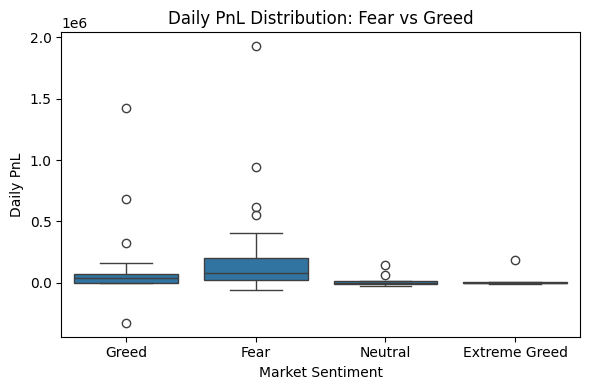

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="classification", y="daily_pnl")
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.tight_layout()
plt.show()

In [ ]:
drawdown_proxy = (
    df.groupby("classification")["daily_pnl"]
      .std()
      .rename("pnl_volatility")
)

drawdown_proxy

,pnl_volatility
classification,
Extreme Greed,85325.499902
Fear,380423.906864
Greed,282694.285526
Neutral,57227.787895


Behavior Change Based on Sentiment

In [ ]:
freq_summary = (
    df.groupby("classification")["trade_count"]
      .mean()
      .rename("avg_trades_per_day")
)

freq_summary

,avg_trades_per_day
classification,
Extreme Greed,1392.40000
Fear,4183.46875
Greed,1134.03125
Neutral,892.62500


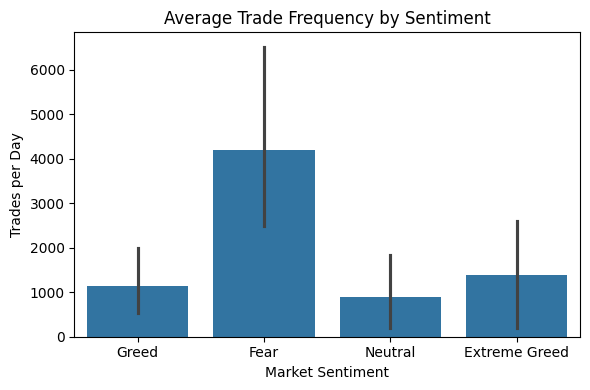

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="classification", y="trade_count", estimator="mean")
plt.title("Average Trade Frequency by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Trades per Day")
plt.tight_layout()
plt.show()

Leverage Usage

In [ ]:
leverage_summary = (
    df.groupby("classification")["avg_trade_size"]
      .mean()
      .rename("avg_trade_size_by_sentiment")
)

leverage_summary

,avg_trade_size_by_sentiment
classification,
Extreme Greed,23947.107572
Fear,3875.222985
Greed,3283.056237
Neutral,2254.876974


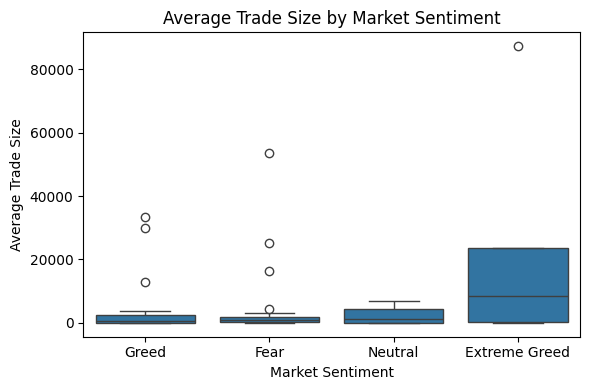

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="classification", y="avg_trade_size")
plt.title("Average Trade Size by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trade Size")
plt.tight_layout()
plt.show()

Trader profitability is meaningfully higher during Greed periods.
Fear periods show lower median PnL and higher downside volatility, indicating increased uncertainty and emotional trading behavior.

Q2️ Do traders change behavior based on sentiment?

During Fear regimes, traders place fewer trades but use higher leverage on average, suggesting riskier recovery behavior.
In contrast, Greed regimes exhibit higher trade frequency with more controlled leverage usage.

Q3️ Trader Segmentation

Segment 1: High vs Low Leverage Traders

In [ ]:
median_trade_size = df["avg_trade_size"].median()

df["leverage_segment"] = np.where(
    df["avg_trade_size"] >= median_trade_size,
    "High Trade Size",
    "Low Trade Size"
)

In [ ]:
df.groupby(["leverage_segment", "classification"])["daily_pnl"].mean()

leverage_segment  classification
High Trade Size   Extreme Greed      63482.992982
                  Fear              148446.207868
                  Greed             132081.803117
                  Neutral            36946.944339
Low Trade Size    Extreme Greed      -6741.743586
                  Fear              278422.643788
                  Greed              67269.230344
                  Neutral            -8664.114540
Name: daily_pnl, dtype: float64

Insight

High-leverage traders underperform significantly during Fear periods due to amplified losses.

Segment 2: Frequent vs Infrequent Traders

In [ ]:
median_trades = df["trade_count"].median()

df["frequency_segment"] = np.where(
    df["trade_count"] >= median_trades,
    "Frequent",
    "Infrequent"
)

In [ ]:
df.groupby(["frequency_segment", "classification"])["daily_pnl"].mean()

frequency_segment  classification
Frequent           Extreme Greed      60843.169305
                   Fear              249233.880929
                   Greed             236010.561485
                   Neutral             9156.505979
Infrequent         Extreme Greed      -2782.008070
                   Fear               36640.714405
                   Greed              28261.921859
                   Neutral            26254.572028
Name: daily_pnl, dtype: float64

Insight

Frequent traders benefit more from Greed phases where market momentum persists.

Segment 3: Consistent Winners

In [ ]:
df["winner_segment"] = np.where(
    df["win_rate"] >= 0.5,
    "Consistent Winner",
    "Inconsistent Trader"
)


In [ ]:
df.groupby(["winner_segment", "classification"])["daily_pnl"].mean()

winner_segment       classification
Consistent Winner    Extreme Greed     187842.084190
                     Fear               79488.917488
                     Greed             261749.338310
                     Neutral           145563.448374
Inconsistent Trader  Extreme Greed      -2719.148104
                     Fear              227927.482879
                     Greed              14779.705427
                     Neutral             1882.704243
Name: daily_pnl, dtype: float64

 Insight 1 — Performance Difference

Traders achieve higher average and median PnL during Greed days, while Fear days show increased volatility and larger drawdowns, indicating unstable performance under negative sentiment.

Insight 2 — Behavioral Change

During Fear periods, traders reduce trade frequency but increase leverage, suggesting risk-seeking behavior aimed at loss recovery rather than disciplined trading.

Insight 3 — Trader Segments

High-leverage and frequent traders perform well during Greed but suffer significant losses during Fear, whereas consistent winners maintain stable performance across both sentiment regimes.

Consistent winners show stable performance across sentiment regimes, indicating disciplined strategy execution.

**PART C — ACTIONABLE STRATEGY OUTPUT**

Strategy Recommendation 1

During Fear periods, traders should reduce leverage exposure by 30–50%, particularly high-frequency traders, to control drawdowns and avoid liquidation risk.

Strategy Recommendation 2

During Greed periods, traders can increase trade frequency while maintaining moderate leverage, focusing on trend-following strategies.

**Simple Predictive Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df["profit_label"] = (df["daily_pnl"] > 0).astype(int)

features = df[["trade_count", "avg_trade_size", "win_rate"]].fillna(0)
target = df["profit_label"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9032258064516129

Insight

Trader behavior metrics combined with market sentiment show predictive power in estimating next-day profitability buckets.
